In [1]:
!pip install swig
!pip install "gymnasium[box2d]"

In [3]:
# import the modules
import gymnasium as gym

# import the necessary packages for torch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
env = gym.make("CarRacing-v3")


obs, info = env.reset()
obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
env.render()
env.close()

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/box2d/car_racing.py:593: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CarRacing-v3", render_mode="rgb_array")
  gym.logger.warn(


In [4]:
AE_loss = []
VQ_VAE_loss = []

In [18]:
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("CarRacing-v3", continuous=True, render_mode="rgb_array")

# ---------- Encoder ----------
class Encoder(nn.Module):
    def __init__(self, image_height, image_width, channels, embedding_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(channels, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)

        dummy = torch.zeros(1, channels, image_height, image_width)
        x = F.relu(self.conv1(dummy))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        self.shape_before_flattening = x.shape[1:]
        flattened_size = x.view(1, -1).shape[1]
        self.fc = nn.Linear(flattened_size, embedding_dim)

    def forward(self, x):
        x = x.float() / 255.0
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# ---------- Decoder ----------
class Decoder(nn.Module):
    def __init__(self, shape_before_flattening, channels, embedding_dim, output_height=96, output_width=96):
        super(Decoder, self).__init__()
        self.shape = shape_before_flattening
        self.output_height = output_height
        self.output_width = output_width

        self.fc = nn.Linear(embedding_dim, np.prod(self.shape))
        self.deconv1 = nn.ConvTranspose2d(self.shape[0], 64, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.fc(x))
        x = x.view(x.size(0), *self.shape)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))
        return x

# ---------- Forward Model (Encoder + Action + Decoder) ----------
class ForwardModel(nn.Module):
    def __init__(self, encoder, decoder, action_dim, embedding_dim):
        super(ForwardModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.action_net = nn.Sequential(
            nn.Linear(action_dim, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim)
        )
        self.fc = nn.Linear(embedding_dim * 2, embedding_dim)

    def forward(self, obs, action):
        obs_emb = self.encoder(obs)
        action_emb = self.action_net(action)
        combined = torch.cat([obs_emb, action_emb], dim=1)
        fused = F.relu(self.fc(combined))
        next_obs_pred = self.decoder(fused)
        return next_obs_pred

# ---------- Utility ----------
def show_rgb_image(image_tensor, title=""):
    image = image_tensor.detach().cpu().numpy()
    if image.ndim == 3 and image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))
    image = (image * 255).astype(np.uint8)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()


embedding_dim = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Build model ----------
obs_sample = env.reset(seed=42)[0]
H, W, C = obs_sample.shape
action_dim = env.action_space.shape[0]

encoder = Encoder(H, W, C, embedding_dim).to(device)
decoder = Decoder(encoder.shape_before_flattening, C, embedding_dim, output_height=H, output_width=W).to(device)
model = ForwardModel(encoder, decoder, action_dim=action_dim, embedding_dim=embedding_dim).to(device)

k = 100             # Number of data collection & retraining cycles
collect_step = 5000  # Samples per cycle
train_epochs = 10
batch_size = 64
AE_loss_per_cycle = []

# ---------- Build model ----------
obs_sample = env.reset(seed=42)[0]
H, W, C = obs_sample.shape
action_dim = env.action_space.shape[0]

encoder = Encoder(H, W, C, embedding_dim).to(device)
decoder = Decoder(encoder.shape_before_flattening, C, embedding_dim, output_height=H, output_width=W).to(device)
model = ForwardModel(encoder, decoder, action_dim=action_dim, embedding_dim=embedding_dim).to(device)


def collect_data(env, steps):
    obs_arr, act_arr, next_arr = [], [], []
    obs, _ = env.reset()
    for _ in tqdm(range(steps), desc="Collecting data"):
        action = env.action_space.sample()
        next_obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        obs_arr.append(torch.tensor(obs.transpose(2, 0, 1), dtype=torch.float))
        next_arr.append(torch.tensor(next_obs.transpose(2, 0, 1), dtype=torch.float))
        act_arr.append(torch.tensor(action, dtype=torch.float))

        if done:
            obs, _ = env.reset()
        else:
            obs = next_obs

    obs_tensor = torch.stack(obs_arr).to(device)
    next_tensor = torch.stack(next_arr).to(device)
    action_tensor = torch.stack(act_arr).to(device)
    return obs_tensor, action_tensor, next_tensor

def train_model(model, obs_tensor, action_tensor, next_tensor, epochs, batch_size):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    model.train()
    losses = []

    for epoch in range(epochs):
        perm = torch.randperm(obs_tensor.size(0))
        total_loss = 0
        for i in range(0, obs_tensor.size(0), batch_size):
            idx = perm[i:i+batch_size]
            obs_batch = obs_tensor[idx] / 255.0
            next_batch = next_tensor[idx] / 255.0
            action_batch = action_tensor[idx]

            optimizer.zero_grad()
            pred_next = model(obs_batch, action_batch)
            loss = loss_fn(pred_next, next_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / (obs_tensor.size(0) / batch_size)
        losses.append(avg_loss)

        print(f"  Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return losses

# ----------- Run k cycles -----------
for cycle in range(k):
    print(f"\n--- Cycle {cycle+1}/{k} ---")
    obs_tensor, action_tensor, next_tensor = collect_data(env, collect_step)
    losses = train_model(model, obs_tensor, action_tensor, next_tensor, train_epochs, batch_size)
    AE_loss.append(losses)




--- Cycle 1/100 ---


  Epoch 1/10, Loss: 0.0200
  Epoch 2/10, Loss: 0.0067
  Epoch 3/10, Loss: 0.0063
  Epoch 4/10, Loss: 0.0062
  Epoch 5/10, Loss: 0.0062
  Epoch 6/10, Loss: 0.0062
  Epoch 7/10, Loss: 0.0062
  Epoch 8/10, Loss: 0.0062
  Epoch 9/10, Loss: 0.0062
  Epoch 10/10, Loss: 0.0062

--- Cycle 2/100 ---


  Epoch 1/10, Loss: 0.0069
  Epoch 2/10, Loss: 0.0061
  Epoch 3/10, Loss: 0.0061
  Epoch 4/10, Loss: 0.0061
  Epoch 5/10, Loss: 0.0061
  Epoch 6/10, Loss: 0.0061
  Epoch 7/10, Loss: 0.0061
  Epoch 8/10, Loss: 0.0061
  Epoch 9/10, Loss: 0.0061
  Epoch 10/10, Loss: 0.0061

--- Cycle 3/100 ---


  Epoch 1/10, Loss: 0.0056
  Epoch 2/10, Loss: 0.0056
  Epoch 3/10, Loss: 0.0056
  Epoch 4/10, Loss: 0.0055
  Epoch 5/10, Loss: 0.0056
  Epoch 6/10, Loss: 0.0056
  Epoch 7/10, Loss: 0.0055
  Epoch 8/10, Loss: 0.0051
  Epoch 9/10, Loss: 0.0026
  Epoch 10/10, Loss: 0.0018

--- Cycle 4/100 ---


  Epoch 1/10, Loss: 0.0016
  Epoch 2/10, Loss: 0.0013
  Epoch 3/10, Loss: 0.0012
  Epoch 4/10, Loss: 0.0011
  Epoch 5/10, Loss: 0.0010
  Epoch 6/10, Loss: 0.0010
  Epoch 7/10, Loss: 0.0009
  Epoch 8/10, Loss: 0.0009
  Epoch 9/10, Loss: 0.0009
  Epoch 10/10, Loss: 0.0008

--- Cycle 5/100 ---


  Epoch 1/10, Loss: 0.0014
  Epoch 2/10, Loss: 0.0011
  Epoch 3/10, Loss: 0.0009
  Epoch 4/10, Loss: 0.0009
  Epoch 5/10, Loss: 0.0009
  Epoch 6/10, Loss: 0.0008
  Epoch 7/10, Loss: 0.0007
  Epoch 8/10, Loss: 0.0007
  Epoch 9/10, Loss: 0.0006
  Epoch 10/10, Loss: 0.0006

--- Cycle 6/100 ---


  Epoch 1/10, Loss: 0.0008
  Epoch 2/10, Loss: 0.0006
  Epoch 3/10, Loss: 0.0006
  Epoch 4/10, Loss: 0.0005
  Epoch 5/10, Loss: 0.0005
  Epoch 6/10, Loss: 0.0005
  Epoch 7/10, Loss: 0.0005
  Epoch 8/10, Loss: 0.0005
  Epoch 9/10, Loss: 0.0004
  Epoch 10/10, Loss: 0.0004

--- Cycle 7/100 ---


  Epoch 1/10, Loss: 0.0008
  Epoch 2/10, Loss: 0.0005
  Epoch 3/10, Loss: 0.0004
  Epoch 4/10, Loss: 0.0004
  Epoch 5/10, Loss: 0.0004
  Epoch 6/10, Loss: 0.0003
  Epoch 7/10, Loss: 0.0003
  Epoch 8/10, Loss: 0.0003
  Epoch 9/10, Loss: 0.0003
  Epoch 10/10, Loss: 0.0003

--- Cycle 8/100 ---


  Epoch 1/10, Loss: 0.0006
  Epoch 2/10, Loss: 0.0004
  Epoch 3/10, Loss: 0.0004
  Epoch 4/10, Loss: 0.0003
  Epoch 5/10, Loss: 0.0003
  Epoch 6/10, Loss: 0.0003
  Epoch 7/10, Loss: 0.0003
  Epoch 8/10, Loss: 0.0003
  Epoch 9/10, Loss: 0.0003
  Epoch 10/10, Loss: 0.0003

--- Cycle 9/100 ---


  Epoch 1/10, Loss: 0.0006
  Epoch 2/10, Loss: 0.0004
  Epoch 3/10, Loss: 0.0004
  Epoch 4/10, Loss: 0.0004
  Epoch 5/10, Loss: 0.0003
  Epoch 6/10, Loss: 0.0003
  Epoch 7/10, Loss: 0.0003
  Epoch 8/10, Loss: 0.0003
  Epoch 9/10, Loss: 0.0003
  Epoch 10/10, Loss: 0.0003

--- Cycle 10/100 ---


  Epoch 1/10, Loss: 0.0006
  Epoch 2/10, Loss: 0.0004
  Epoch 3/10, Loss: 0.0003
  Epoch 4/10, Loss: 0.0003
  Epoch 5/10, Loss: 0.0003
  Epoch 6/10, Loss: 0.0003
  Epoch 7/10, Loss: 0.0003
  Epoch 8/10, Loss: 0.0002
  Epoch 9/10, Loss: 0.0002
  Epoch 10/10, Loss: 0.0002

--- Cycle 11/100 ---


  Epoch 1/10, Loss: 0.0005
  Epoch 2/10, Loss: 0.0003
  Epoch 3/10, Loss: 0.0003
  Epoch 4/10, Loss: 0.0003
  Epoch 5/10, Loss: 0.0003
  Epoch 6/10, Loss: 0.0002
  Epoch 7/10, Loss: 0.0002
  Epoch 8/10, Loss: 0.0003
  Epoch 9/10, Loss: 0.0002
  Epoch 10/10, Loss: 0.0002

--- Cycle 12/100 ---


  Epoch 1/10, Loss: 0.0005
  Epoch 2/10, Loss: 0.0003
  Epoch 3/10, Loss: 0.0003
  Epoch 4/10, Loss: 0.0002
  Epoch 5/10, Loss: 0.0002
  Epoch 6/10, Loss: 0.0002
  Epoch 7/10, Loss: 0.0002
  Epoch 8/10, Loss: 0.0002
  Epoch 9/10, Loss: 0.0002
  Epoch 10/10, Loss: 0.0002

--- Cycle 13/100 ---


  Epoch 1/10, Loss: 0.0005
  Epoch 2/10, Loss: 0.0003
  Epoch 3/10, Loss: 0.0002
  Epoch 4/10, Loss: 0.0002
  Epoch 5/10, Loss: 0.0002
  Epoch 6/10, Loss: 0.0002
  Epoch 7/10, Loss: 0.0002
  Epoch 8/10, Loss: 0.0002
  Epoch 9/10, Loss: 0.0002
  Epoch 10/10, Loss: 0.0002

--- Cycle 14/100 ---


KeyboardInterrupt: 

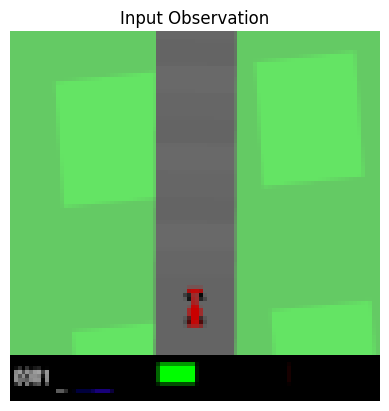

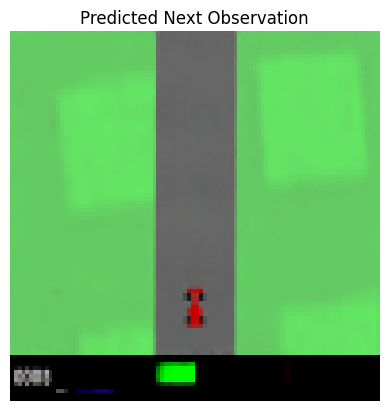

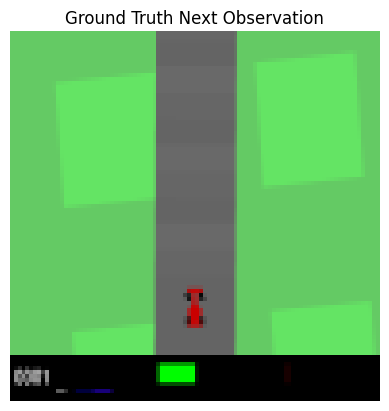

In [23]:
# ---------- Inference with k random steps ----------
k = 100  # number of random steps before evaluating

with torch.no_grad():
    obs, _ = env.reset(seed=np.random.randint(10000))

    for _ in range(k):
        action = env.action_space.sample()
        next_obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        if done:
            obs, _ = env.reset(seed=np.random.randint(10000))
        else:
            obs = next_obs

    # Prepare input tensors
    obs_tensor_input = torch.tensor(obs.transpose(2, 0, 1), dtype=torch.float).unsqueeze(0).to(device) / 255.0
    action_tensor_input = torch.tensor(action, dtype=torch.float).unsqueeze(0).to(device)

    # Ground truth next observation (after taking the action)
    next_obs, _, _, _, _ = env.step(action)
    gt_next_tensor = torch.tensor(next_obs.transpose(2, 0, 1), dtype=torch.float)

    # Model prediction
    pred_next = model(obs_tensor_input, action_tensor_input)[0]

    # Visualization
    show_rgb_image(obs_tensor_input[0], title="Input Observation")
    show_rgb_image(pred_next, title="Predicted Next Observation")
    show_rgb_image(gt_next_tensor / 255.0, title="Ground Truth Next Observation")


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VectorQuantizer(nn.Module):
    def __init__(self, code_book_size, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.code_book_size = code_book_size
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        self.embedding = nn.Embedding(code_book_size, embedding_dim)
        self.embedding.weight.data.uniform_(-1/code_book_size, 1/code_book_size)

    def forward(self, inputs):
        inputs = inputs.permute(0, 2, 3, 1).contiguous()  # BSxCxHxW --> BSxHxWxC
        input_shape = inputs.shape

        flat_input = inputs.view(-1, 1, self.embedding_dim)  # BSxHxWxC --> BS*H*Wx1xC

        # Calculate the distance between each embedding and each codebook vector
        distances = (flat_input - self.embedding.weight.unsqueeze(0)).pow(2).mean(2)  # BS*H*WxN

        # Find the closest codebook vector
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)  # BS*H*Wx1

        # Select that codebook vector
        quantized = self.embedding(encoding_indices).view(input_shape)

        # Create loss that pulls encoder embeddings and codebook vector selected
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # Reconstruct quantized representation using the encoder embeddings to allow for
        # backpropagation of gradients into encoder
        if self.training:
            quantized = inputs + (quantized - inputs).detach()

        return loss, quantized.permute(0, 3, 1, 2).contiguous(), encoding_indices.reshape(input_shape[0], -1)


class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.norm1 = nn.GroupNorm(8, channels)
        self.conv1 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.norm2 = nn.GroupNorm(8, channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, 1, 1)

    def forward(self, x):
        skip = x

        x = F.elu(self.norm1(x))
        x = F.elu(self.norm2(self.conv1(x)))
        x = self.conv2(x) + skip
        return x


# We split up our network into two parts, the Encoder and the Decoder
class DownBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(DownBlock, self).__init__()
        self.bn1 = nn.GroupNorm(8, channels_in)
        self.conv1 = nn.Conv2d(channels_in, channels_out, 3, 2, 1)
        self.bn2 = nn.GroupNorm(8, channels_out)
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, 1, 1)

        self.conv3 = nn.Conv2d(channels_in, channels_out, 3, 2, 1)

    def forward(self, x):
        x = F.elu(self.bn1(x))

        x_skip = self.conv3(x)

        x = F.elu(self.bn2(self.conv1(x)))
        return self.conv2(x) + x_skip


# We split up our network into two parts, the Encoder and the Decoder
class UpBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(UpBlock, self).__init__()
        self.bn1 = nn.GroupNorm(8, channels_in)

        self.conv1 = nn.Conv2d(channels_in, channels_in, 3, 1, 1)
        self.bn2 = nn.GroupNorm(8, channels_in)

        self.conv2 = nn.Conv2d(channels_in, channels_out, 3, 1, 1)

        self.conv3 = nn.Conv2d(channels_in, channels_out, 3, 1, 1)
        self.up_nn = nn.Upsample(scale_factor=2, mode="nearest")

    def forward(self, x_in):
        x = self.up_nn(F.elu(self.bn1(x_in)))

        x_skip = self.conv3(x)

        x = F.elu(self.bn2(self.conv1(x)))
        return self.conv2(x) + x_skip


# We split up our network into two parts, the Encoder and the Decoder
class Encoder(nn.Module):
    def __init__(self, channels, ch=32, latent_channels=32):
        super(Encoder, self).__init__()
        self.conv_1 = nn.Conv2d(channels, ch, 3, 1, 1)

        self.conv_block1 = DownBlock(ch, ch * 2)
        self.conv_block2 = DownBlock(ch * 2, ch * 4)

        # Instead of flattening (and then having to unflatten) out our feature map and
        # putting it through a linear layer we can just use a conv layer
        # where the kernal is the same size as the feature map
        # (in practice it's the same thing)
        self.res_block_1 = ResBlock(ch * 4)
        self.res_block_2 = ResBlock(ch * 4)
        self.res_block_3 = ResBlock(ch * 4)

        self.conv_out = nn.Conv2d(4 * ch, latent_channels, 3, 1, 1)

    def forward(self, x):
        x = self.conv_1(x)

        x = self.conv_block1(x)
        x = self.conv_block2(x)

        x = self.res_block_1(x)
        x = self.res_block_2(x)
        x = F.elu(self.res_block_3(x))

        return self.conv_out(x)


class Decoder(nn.Module):
    def __init__(self, channels, ch = 32, latent_channels = 32):
        super(Decoder, self).__init__()

        self.conv1 = nn.Conv2d(latent_channels, 4 * ch, 3, 1, 1)
        self.res_block_1 = ResBlock(ch * 4)
        self.res_block_2 = ResBlock(ch * 4)
        self.res_block_2 = ResBlock(ch * 4)

        self.conv_block1 = UpBlock(4 * ch, 2 * ch)
        self.conv_block2 = UpBlock(2 * ch, ch)
        self.conv_out = nn.Conv2d(ch, channels, 3, 1, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.res_block_1(x)
        x = self.res_block_2(x)
        x = self.res_block_2(x)

        x = self.conv_block1(x)
        x = self.conv_block2(x)

        return torch.tanh(self.conv_out(x))

class VQVAE(nn.Module):
    def __init__(self, channel_in, ch=16, latent_channels=32, code_book_size=64, commitment_cost=0.25):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(channels=channel_in, ch=ch, latent_channels=latent_channels)

        self.vq = VectorQuantizer(code_book_size=code_book_size,
                                  embedding_dim=latent_channels,
                                  commitment_cost=commitment_cost)

        self.decoder = Decoder(channels=channel_in, ch=ch, latent_channels=latent_channels)

    def encode(self, x):
        encoding = self.encoder(x)
        vq_loss, quantized, encoding_indices = self.vq(encoding)
        return vq_loss, quantized, encoding_indices

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        vq_loss, quantized, encoding_indices = self.encode(x)
        recon = self.decode(quantized)

        return recon, vq_loss, quantized


# VQ VAE

In [ ]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# ---- Utility ----
def show_rgb_image(image_tensor, title=""):
    image = image_tensor.detach().cpu().numpy()
    if image.ndim == 3 and image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))
    image = (image * 255).astype(np.uint8)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# ---- Setup ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("CarRacing-v3", render_mode="rgb_array")
obs_sample = env.reset(seed=42)[0]
C, H, W = obs_sample.shape[2], obs_sample.shape[0], obs_sample.shape[1]


# ---- VQ-VAE model ----
# from your_module import VQVAE
vqvae = VQVAE(channel_in=C, ch=16, latent_channels=embedding_dim, code_book_size=32).to(device)
optimizer = optim.Adam(vqvae.parameters(), lr=1e-3)
mse_loss = torch.nn.MSELoss()

VQ_VAE_loss_per_cycle = []

# ---- Data Collection Function ----
def collect_observations(env, steps):
    obs_arr = []
    obs = env.reset(seed=np.random.randint(10000))[0]
    for _ in tqdm(range(steps), desc="Collecting observations"):
        action = env.action_space.sample()
        next_obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        obs_arr.append(torch.tensor(next_obs.transpose(2, 0, 1), dtype=torch.float))

        if done:
            obs = env.reset(seed=np.random.randint(10000))[0]
        else:
            obs = next_obs

    obs_tensor = torch.stack(obs_arr) / 255.0
    return obs_tensor

# ---- Training Function ----
def train_vqvae(vqvae, optimizer, data_tensor, train_epochs, batch_size):
    dataset = DataLoader(TensorDataset(data_tensor), batch_size=batch_size, shuffle=True)
    losses = []
    vqvae.train()
    for epoch in range(train_epochs):
        total_loss = 0
        for (obs_batch,) in dataset:
            obs_batch = obs_batch.to(device)
            recon, vq_loss, _ = vqvae(obs_batch)
            recon_loss = mse_loss(recon, obs_batch)
            loss = recon_loss + vq_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataset)
        losses.append(avg_loss)
        print(f"  Epoch {epoch+1}/{train_epochs}, Loss: {avg_loss:.4f}")
    return losses

# ---- Run k cycles ----
for cycle in range(k):
    print(f"\n--- Cycle {cycle+1}/{k} ---")
    obs_tensor = collect_observations(env, collect_step)
    cycle_losses = train_vqvae(vqvae, optimizer, obs_tensor, train_epochs, batch_size)
    VQ_VAE_loss.append(cycle_losses)


# ---- Inference ----
vqvae.eval()
with torch.no_grad():
    sample = obs_tensor[0].unsqueeze(0).to(device)
    recon, _, _ = vqvae(sample)
    show_rgb_image(sample[0], title="Original Observation")
    show_rgb_image(recon[0], title="Reconstructed Observation")



--- Cycle 1/100 ---


  Epoch 1/10, Loss: 0.3272
  Epoch 2/10, Loss: 0.0162
  Epoch 3/10, Loss: 0.0108
  Epoch 4/10, Loss: 0.0065
  Epoch 5/10, Loss: 0.0056
  Epoch 6/10, Loss: 0.0049
  Epoch 7/10, Loss: 0.0049
  Epoch 8/10, Loss: 0.0037
  Epoch 9/10, Loss: 0.0033
  Epoch 10/10, Loss: 0.0035

--- Cycle 2/100 ---


  Epoch 1/10, Loss: 0.0032
  Epoch 2/10, Loss: 0.0031
  Epoch 3/10, Loss: 0.0530
  Epoch 4/10, Loss: 0.0059
  Epoch 5/10, Loss: 0.0043
  Epoch 6/10, Loss: 0.0034
  Epoch 7/10, Loss: 0.0030
  Epoch 8/10, Loss: 0.0028
  Epoch 9/10, Loss: 0.0026
  Epoch 10/10, Loss: 0.0025

--- Cycle 3/100 ---


  Epoch 1/10, Loss: 0.0025
  Epoch 2/10, Loss: 0.0023
  Epoch 3/10, Loss: 0.0022
  Epoch 4/10, Loss: 0.0022
  Epoch 5/10, Loss: 0.0021
  Epoch 6/10, Loss: 0.0020
  Epoch 7/10, Loss: 0.0019
  Epoch 8/10, Loss: 0.0020
  Epoch 9/10, Loss: 0.0019
  Epoch 10/10, Loss: 0.0018

--- Cycle 4/100 ---


  Epoch 1/10, Loss: 0.0018
  Epoch 2/10, Loss: 0.0017
  Epoch 3/10, Loss: 0.0015
  Epoch 4/10, Loss: 0.0014
  Epoch 5/10, Loss: 0.0014
  Epoch 6/10, Loss: 0.0013
  Epoch 7/10, Loss: 0.0013
  Epoch 8/10, Loss: 0.0013
  Epoch 9/10, Loss: 0.0012
  Epoch 10/10, Loss: 0.0012

--- Cycle 5/100 ---


  Epoch 1/10, Loss: 0.0013
  Epoch 2/10, Loss: 0.0013


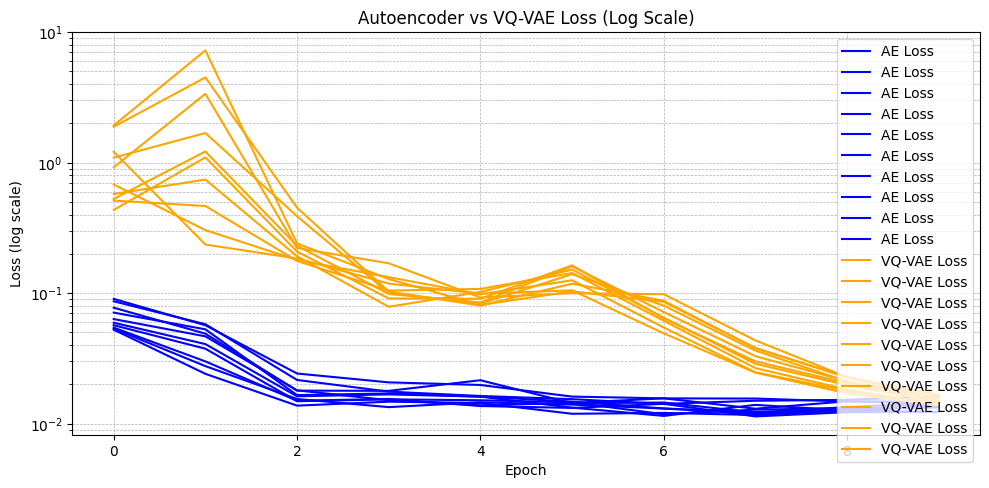

In [17]:
import matplotlib.pyplot as plt

# Example: AE_loss = [...], VQ_VAE_loss = [...]

plt.figure(figsize=(10, 5))
plt.plot(AE_loss, label="AE Loss", color="blue")
plt.plot(VQ_VAE_loss, label="VQ-VAE Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.title("Autoencoder vs VQ-VAE Loss (Log Scale)")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()
